# Tutorial: Creating Recommender Systems Datasets in Scientific Fields


<ul>
    <li><a href="#1">1. Data retrieval and cleaning</a></li>
</ul>
   
<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#1.1">1.1.Import libraries</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#1.2">1.2. Retrieve CORD-19</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#1.3">1.3. Exploring the articles of the dataset</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#1.4">1.4. Selecting a sample of articles to build our scientific recommendation dataset</a></li>
</ul>

<ul>
   <li><a href="#2">2. Named Entity Recognition (NER) + Named Entity Linking (NEL)</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#2.1">2.1. Import libraries</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#2.2">2.2. Configure MER</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#2.3">2.3. Import stop words vocabulary and tokenizer</a></li>
</ul>


<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#2.4">2.4. Extract the entities in a single file</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#2.5">2.5. Create entity files</a></li>
</ul>

<ul>
   <li><a href="#3">3. Creating the recommendation dataset</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#3.1">3.1. Import libraries</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#3.2">3.2. Import user-defined-functions</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#3.3">3.3. Get entities labels</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#4.4">3.4. Loading ontologies</a></li>
</ul>

<ul>
   <li>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="#3.5">3.5. Save data</a></li>
</ul>



















<a id="1"></a>

## 1. Data retrieval + cleaning

**Goal**: To retrieve the [COVID-19 Open Research Dataset (CORD-19)](https://www.semanticscholar.org/cord19) and to select a sample of complete English articles (authors' info, title, body text) to build a scientific recommendation dataset.

CORD-19 includes coronavirus-related research articles extracted from several sources, such as PubMed, bioRxiv, medRxiv, WHO.

<a id="1.1"></a>
### 1.1 Import libraries

In [ ]:
import json
import os
import pandas as pd
import requests
import sys
from langdetect import detect
sys.path.append("./")

<a id="1.2"></a>
### 1.2. Retrieve CORD-19

CORD-19 is a large dataset, so in this tutorial we are going to use a smaller version of the dataset. 
This version is located under the directory "cord19_small":

In [ ]:
os.chdir('data')
os.system('tar -xvf cord19_small.tar.xz')
os.chdir('../')

However, if you want to retrieve the entire dataset, you can run the following code:

In [ ]:
os.chdir('data')
         
version = 'cord-19_2020-05-12.tar.gz'

url = 'https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/' + version

response = requests.get(url)

os.system('tar -xvf cord-19_2020-05-12.tar.gz')
os.chdir('../')

Let's explore the contents of the dataset directory, particularly, the metadata file.

In [ ]:
dataset_dir = 'data/cord19_small/'
metadata_filepath = dataset_dir + 'metadata.csv'

metadata = pd.read_csv(metadata_filepath, sep = ',', quotechar = '"',  encoding = 'utf-8', dtype=str) 

Now we have a DataFrame with the contents of the metadata file.

To print column names and first row:

In [ ]:
metadata.head(1)

To access individual rows/articles:

In [ ]:
metadata.loc[0]

To access the individual column title':

In [ ]:
metadata['title']

Let's check the summary statistics:

In [ ]:
metadata.count()

By looking at the statistics, we can see that the number of records with data for the column 'cord_uid' is higher than the number of records with data for the column 'authors'. 

For our dataset, we only want to include articles with the following characteristics:
- authors' information
- available title
- available body text
- article text expressed in English
- non-duplicate articles

<a id="1.3"></a>

### 1.3. Exploring the articles of the dataset

Let's consider the first article appearing in the metadata file.
To check if information about the article's author is available:

In [ ]:
metadata.loc[0]['authors']

To check if there is an available title:

In [ ]:
metadata.loc[0]['title']

We can see that the title is expressed in English, but it would not be efficient to check the language of every article in the dataset, so we will apply the language detection tool [langdetect](https://pypi.org/project/langdetect/):

In [ ]:
title1 = metadata.loc[0]['title']

title1_lang = (title1)

print("Title:", title1, "\nLanguage:", title1_lang)

The tool detects English as the language of the title.

Let's check another article:

In [ ]:
title2 = metadata.loc[144]['title']

title2_lang = detect(title2)

print("Title:", title2, "\nLanguage:", title2_lang)

In this case, the tool detects german ('de') as the language of the title.

Now, we want to check if there is an available abstract for the first article:

In [ ]:
metadata.loc[0]['abstract']

The metadata file does not contain the article's text besides abstract and title, but we can access the file associated with the article using the provided information in the columns 'pdf_json_files' or 'pmc_json_files':

In [ ]:
metadata.loc[0]['pdf_json_files']

Let's open the file, which is in [JSON](https://www.json.org/json-en.html) format:

In [ ]:
article1_filepath = dataset_dir + metadata.loc[0]['pdf_json_files']

with open(article1_filepath, encoding='utf-8') as article1_file:
    article1_data = json.load(article1_file)

Now we have the file content stored in a dictionary with the following keys:

In [ ]:
article1_data.keys()

The article content is the following:

In [ ]:
article1_data

Let's check the body text:

In [ ]:
body_text = article1_data['body_text']
body_text

We have a list of dictionaries, each dictionary is a paragraph belonging to a given section of the article. We want to join the different parts text in a single string: 

In [ ]:
article1_text = str()

for paragraph in body_text:
    article1_text += paragraph['text'] + '\n'

article1_text

All good! We will include this article in our dataset.

<a id="1.4"></a>

### 1.4. Selecting a sample of articles to build our scientific recommendation dataset

Instead of repating each operation for each file individually, let us adapt our code to automatically select a sample containing 100 preprocessed articles. 

First, create the output directory:

In [ ]:
out_dir = 'data/sample/'

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

Then, initiallize the necessary variables:

In [ ]:
max_articles = 100 #number of articles to include in the sample
dataset_dir = 'data/cord19_small/'
metadata_filepath = dataset_dir + 'metadata.csv'
valid_articles_count = int()
out_articles_ids = list()

Open the metadata file:

In [ ]:
metadata = pd.read_csv(metadata_filepath, sep = ',', quotechar = '"',  encoding = 'utf-8', dtype=str) 

Then iterate over the records in the metadata file and choose only the relevant ones:

In [ ]:
valid_articles_count = int()
blacklist = str()
blacklist_count = int()

for index, record in metadata.iterrows():
    invalid_article = True
    
    if valid_articles_count <= max_articles:
        
        if record['pubmed_id'] not in out_articles_ids:
            
            if type(record['sha']) != float:

                if record['authors'] != '':    

                    if record['title'] != '':
                        title = record['title']
                        title_lang = detect(title)
                        article_filepath = record['pdf_json_files']
                        
                        if article_filepath != '': # to consider onyl articles from the pdf_json directory

                            if title_lang == 'en'  \
                                and type(article_filepath) != float  \
                                and article_filepath.count("document") == 1:

                                article_filepath_up = dataset_dir + record['pdf_json_files']

                                with open(article_filepath_up, encoding='utf-8') as article_file:
                                    article_data = json.load(article_file)

                                if 'body_text' in article_data.keys(): # the article is valid
                                    valid_articles_count += 1
                                    invalid_article = False

                                    # open the article file to check if it contains all info
                                    with open(article_filepath_up) as article_file:
                                        article_data = json.load(article_file)

                                    # correct the info of the article with info present in metadata file
                                    changed_article = False

                                    if article_data['metadata']['title'] == '':
                                        article_data['metadata']['title'] = record['title']
                                        changed_article = True

                                    if article_data['metadata']['authors'] == []:
                                        article_data['metadata']['authors'] = record['authors']

                                    # output or copy article file to out_dir
                                    if changed_article:

                                        with open(out_dir + record['sha'] + '.json', 'w') as out_file:
                                            out_file.write(json.dumps(article_data, indent=4, ensure_ascii=False))

                                    else:
                                        command = 'cp '  \
                                                  + article_filepath_up + ' ' \
                                                  + out_dir  \
                                                  + record['sha'] + '.json'

                                        os.system(command)
        
        if invalid_article: # store article pubmed id in blacklist file
            blacklist += record['pubmed_id'] + "\n"
            blacklist_count += 1
            
    if valid_articles_count == max_articles:
        total_articles = index + 1
        break

#Create blacklist file with info about invalid articles
with open('data/blacklist/blacklist_articles.txt', 'w') as blacklist_file:
    blacklist_file.write(blacklist)
    blacklist_file.close()

print("Invalid articles:", str(blacklist_count))

If you were not able to run the code, you can uncompress the file 'sample.tar.xz' under 'data' directory.

Let's check if the output directory contain the desired number of articles (max_articles):

In [ ]:
article_count = len(os.listdir(out_dir))
assert article_count == max_articles, 'Invalid number of article(s): {}! Expected number: {}'.format(article_count, max_articles)

At the end of this section, we now have a sample including 100 articles that will be the basis of our scientific recommendation dataset.

<a id="2"></a>

## 2. Named Entity Recognition (NER) + Named Entity Linking (NEL)

**Goal**: To recognize chemical and disease entities in the retrieved articles and to link them to the respective ontology identifiers.

We are going to use the [Disease Ontology](https://disease-ontology.org/) (DO), and the [Chemical Entities of Biological Interest](https://www.ebi.ac.uk/chebi/) (ChEBI) ontology.

To perform NER and NEL, we are going to apply Minimal Named-Entity Recognizer [MER](https://pypi.org/project/merpy/) tool.

<a id="2.1"></a>
### 2.1. Import libraries

In [ ]:
import merpy
import multiprocessing
from collections import Counter

<a id="2.2"></a>
### 2.2. Configure MER

First, we need to download the owl file associated with ChEBI:

In [ ]:
merpy.download_lexicon("ftp://ftp.ebi.ac.uk/pub/databases/chebi/ontology/chebi.owl",
                       "chebi", ltype="owl")

Then, we need to process the downloaded file into a lexicon that MER can use:

In [ ]:
merpy.process_lexicon("chebi", ltype="owl")

We are going to delete obsolete concepts still present in the ontology file:

In [ ]:
merpy.delete_obsolete("chebi")

We need to repeat the operations for the DO:

In [ ]:
merpy.download_lexicon("http://purl.obolibrary.org/obo/doid.owl", 
                        "do", ltype="owl")
            
merpy.process_lexicon("do", ltype="owl")

merpy.delete_obsolete("do")

Let's check the lexicons available for MER:

In [ ]:
merpy.show_lexicons()

<a id="2.3"></a>
### 2.3. Import stop words vocabulary and tokenizer

Stop words are common words of a given language (for example the words 'the', 'and', 'in'). A typical pre-processing step is to tokenize the text and remove the stopwords. For that, we are going to import NLTK's list of english stopwords and use the NLTK tokenizer.

In [ ]:
import nltk 
nltk.download('punkt')

from nltk.corpus import stopwords

nltk.download('stopwords')

from nltk.tokenize import word_tokenize

all_stopwords = stopwords.words('english')

We are going to extend the stop words vocabulary by adding stop words associated with ChEBI and DO:

In [ ]:
kbs_stopwords = list()
blacklist_dir = 'data/blacklist/'
filenames = ['chebi.txt', 'doid.txt']

for filename in filenames:
    
    with open(blacklist_dir + filename, 'r') as backlist_file:
        stopwords = [content.strip('\n') for content in backlist_file.readlines()]
        kbs_stopwords.extend(stopwords)
        backlist_file.close()

#Extend stop words vocabulary with the retrieved KBs stopwords
all_stopwords.extend(kbs_stopwords)

<a id="2.4"></a>
### 2.4. Extract the entities in a single file

Let's retrieve a file from the articles sample:

In [ ]:
dataset_dir = 'data/sample/'

with open(dataset_dir + '87390d2ae28407b3e03e60a6b24a7fd99ed7229a.json') as article1_file:
    article_data = json.load(article1_file)

Let's check the contents of the article:

In [ ]:
article_data.keys()

We want to recognize the entities present in title, abstract, and body. 

First, let's retrieve the title, which is a value associated with the key 'metadata':

In [ ]:
title = article_data['metadata']['title']
title

Let's tokenize the title:

In [ ]:
title_tokens = word_tokenize(title)
title_tokens

And remove the tokens relative to stop words:

In [ ]:
title_tokens_up = [word for word in title_tokens if not word in all_stopwords]
title_tokens_up

And rebuild the title without the stop words:

In [ ]:
title_up = (' ').join(title_tokens_up)
title_up

Then, we apply MER to the preprocessed title in order to recognize disease entities and to link them to DO concepts:

In [ ]:
merpy.get_entities(title_up, 'do')

Let's check if the annotations make sense. For instance, access the link http://purl.obolibrary.org/obo/DOID_2945.

The entity 'SARS' in the article was linked to the DO concept 'severe acute respiratory syndrome' with the identifier 'DOID:2945', which seems correct!

Let's apply MER to recognize chemical entities and to link them to ChEBI concepts:

In [ ]:
merpy.get_entities(title_up, 'chebi')

Accessing the link http://purl.obolibrary.org/obo/CHEBI_35341, we can see that the entity 'Steroids' was linked to the ChEBI concept 'steroid', which has the identifier 'CHEBI:35341'.

We add the disease and chemical entities to a single list:

In [ ]:
title_entities = merpy.get_entities(title_up, 'do') + merpy.get_entities(title_up, 'chebi')

title_entities

Now, we are going to apply MER to recognize entities in abstract:

In [ ]:
abstract = article_data['abstract'][0]['text']

#Tokenize and remove stop words
abstract_tokens = word_tokenize(abstract)
abstract_tokens_up = [word for word in abstract_tokens if not word in all_stopwords]
abstract_up = (' ').join(abstract_tokens_up)

#Entity recognition and linking 
abstract_entities = merpy.get_entities(abstract_up, 'do') + merpy.get_entities(abstract_up, 'chebi')

abstract_entities

Let's apply MER in the text associated with the body of the article:

In [ ]:
body = str()

for section in article_data['body_text']:
    body += section['text'] + "\n"
    
#Tokenize and remove stop words
body_tokens = word_tokenize(body)
body_tokens_up = [word for word in body_tokens if not word in all_stopwords]
body_up = (' ').join(body_tokens_up)

#Entity recognition and linking 
body_entities = merpy.get_entities(body_up, "do") + merpy.get_entities(body_up, "chebi")

body_entities

At last, we need to obtain information about the frequency of each ontology identifier in the document:

In [ ]:
total_entities = title_entities + abstract_entities + body_entities

all_uris = [entity[3] for entity in total_entities]

entity_counter = Counter(all_uris)

entity_counter

To sort the URIs by descending order:

In [ ]:
entity_counter = {
    k: v 
    for k, v in sorted(entity_counter.items(), key=lambda item: item[1], reverse=True)
    }

entity_counter 

<a id="2.5"></a>
### 2.5. Create entity files

We need to adapt our code to perform NER and NEL in all documents of our sample.

First, create the output dir:

In [ ]:
out_dir = 'data/sample_entities/'

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

Next, we are going to iterate over each file present in the sample directory, annotate it, and create the respective entity file:

In [ ]:
def annotate_doc(article):
    
    article_filepath = 'data/sample/' + article  

    with open(article_filepath) as input_file:
        article_data = json.load(input_file)

    doc_output = {'id': str(), 'entities': {}, 'sections': {'title': [], 'abstract': [], 'body': []}}
    
    doc_output['id'] = article_data['paper_id']
   
    #Annotate the title
    title = article_data['metadata']['title']
    
    #Tokenize and remove stop words
    title_tokens = word_tokenize(title)
    title_tokens_up = [word for word in title_tokens if not word in all_stopwords]
    title_up = (' ').join(title_tokens_up)
    
    #Entity recognition and linking
    title_entities = merpy.get_entities(title_up, 'do') + merpy.get_entities(title_up, 'chebi')
    doc_output['sections']['title'] = title_entities
    
    #Annotate the abstract
    if article_data['abstract'] != []:
        abstract = article_data['abstract'][0]['text']
        
        #Tokenize and remove stop words
        abstract_tokens = word_tokenize(abstract)
        abstract_tokens_up = [word for word in abstract_tokens if not word in all_stopwords]
        abstract_up = (' ').join(abstract_tokens_up)
        
        #Entity recognition and linking
        abstract_entities = merpy.get_entities(abstract_up, 'do') + merpy.get_entities(abstract_up, 'chebi')
        doc_output['sections']['abstract'] = abstract_entities
    
    else:
        abstract_entities = []

    #Combine the several paragraphs of the body text and annotate it
    body = str()

    for section in article_data['body_text']:
        body += section['text'] + '\n'
    
    #Tokenize and remove stop words
    body_tokens = word_tokenize(body)
    body_tokens_up = [word for word in body_tokens if not word in all_stopwords]
    body_up = (' ').join(body_tokens_up)    
        
    #Entity recognition and linking
    body_entities = merpy.get_entities(body_up, 'do') + merpy.get_entities(body_up, 'chebi')
    doc_output['sections']['body'] = body_entities

    # Count URIs frequencies and sort them
    total_entities = title_entities + abstract_entities + body_entities
    all_uris = [entity[3] for entity in total_entities if len(entity)==4]
    entity_counter = Counter(all_uris)
    
    doc_output['entities'] = {
        k: v 
        for k, v in sorted(entity_counter.items(), key=lambda item: item[1], reverse=True)
        }
    
    #Generate JSON file with output
    out_filepath = out_dir + doc_output['id'] + '_entities.json'
    
    with open(out_filepath, 'w') as out_file:
        out_file.write(json.dumps(doc_output, indent=4))
        

article_dir = 'data/sample/'
        
with multiprocessing.Pool(processes=10) as pool: 
    # change the number of processes according to number of available cores
    outputs = pool.map(annotate_doc, [article for article in os.listdir(article_dir)], chunksize=10)
    pool.close()

If you were not able to run the previous code, you can extract the file 'sample_entities.tar.xz' under 'data' directory

Now we have both the article files ('data/sample' directory) and the respective entities files ('data/sample_entities' directory), and the next step will be the generation of the scientific recomendation dataset using the LIBRETTI algorithm.

<a id="3"></a>
## 3. Create the recommendation dataset

<a id="3.1"></a>
### 3.1. Import libraries

In [ ]:
import sys
import numpy as np
import time
from datetime import date, datetime

<a id="3.2"></a>
### 3.2. Import user-defined-functions

In [ ]:
from util.utils import *
from util.utils2json import *
from util.functions import *
from util.utils2ontologies import *
from util.utils2pubmed import *

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

Entities defined by user, our example will work with chebi and doid ontologies

In [ ]:
# if entities is defined by user then saved it in a list
active_lexicons = []
is_chebi, is_do, is_go, is_hp = True, True, False, False

active_lexicons.append('chebi')   
active_lexicons.append('do')   

Path of original' json and entities' json folder, blacklist and metadata

In [ ]:
original_json_folder = '../data/sample/'
entities_json_folder = '../data/sample_entities/'
path_to_blacklist = '../data/blacklist/blacklist_articles.txt'
path_to_metadata = '../data/metadata.csv'

In [ ]:
entities_list_of_json_files = list_files_in_directory(path=entities_json_folder)
#print(entities_list_of_json_files)

In [ ]:
##### Get all articles id that cannot be considered in use case 

In [ ]:
articles_blacklist = get_blacklist(file=path_to_blacklist)
print(articles_blacklist)
metadata = pd.read_csv(path_to_metadata)

In [ ]:
user_item_rating_all = []
count = 0
#entities_list_of_json_files=['PMC7176216_entities.json']
for file in entities_list_of_json_files:
    # ## Exception
    if file.replace('_entities.json','') in articles_blacklist:
        continue
    # if file.startswith('PMC'):
    #     continue    
    print(count, "-", len(entities_list_of_json_files))            
    print(file)
        
    # check valid json file, i.e. contains values
    try:
        j_file_entities = open_json_file_pd(path=entities_json_folder, file=file)           
    except Exception as e:
        print(f'Json file does not contain values. Error message {e}')
        set_blacklist(file=path_to_blacklist, line=file.replace('_entities.json',''))
        continue
    
    df_entities = get_entities_id(get_entities(j_file_entities))
    if df_entities.empty:
        print(f'Json file does not contain values.')
        set_blacklist(file=path_to_blacklist, line=file.replace('_entities.json',''))
        continue    
    
    print(df_entities)
    article_id = get_article_id(j_file_entities)
    
    # check valid json file, i.e. contains values
    try:
        j_file_original = open_json_file(path=original_json_folder, file=article_id)
        #print(j_file_original)
    except Exception as e:
        print(f'Original json file does not exist. Error message {e}')
        set_blacklist(file=path_to_blacklist, line=file.replace('_entities.json',''))
        continue    
    
    # check if json file contains authors, otherwise try to find them in metadata.csv
    # if value remains null them put this article in the blacklist file
    list_of_authors = get_authors_names(data=j_file_original)
    
###  ---- Metadata ----
    # Some datas return an array, then we convert to a list and get first element
    publish_date=''      
    if article_id.startswith('PMC'):
        try:
            publish_date = metadata[metadata.pmcid == article_id].\
                publish_time.map(lambda v: v.split('-')[0]).tolist()[0]
        except Exception as e:    
            try:
                print(f'Find publish date, now with metapub. Error message {e}')            
                publish_date = get_year_by_metapub(pmcid=article_id) 
            except Exception as e: 
                try:                    
                    print(f'Find publish date, now with Bio. Error message {e}') 
                    pmid = get_pmid(pmcid=article_id) 
                    publish_date = get_year_by_bio(pmid) 
                except Exception as e:
                    print(f'Find publish date, now with metapub. Error message {e}')    
                
        finally:
            pass                                         
    else:
        try:
            publish_date = metadata[metadata.sha == article_id].\
                publish_time.map(lambda v: v.split('-')[0]).tolist()[0]
        finally:
            pass  

    print(publish_date)
    if publish_date==None:
        set_blacklist(file=path_to_blacklist, line=file.replace('_entities.json',''))
        continue
    
    # if authors is empty we will find in metadata.csv file
    if len(list_of_authors)==0:
        ##if string is NaN
        try:
            if article_id.startswith('PMC'):
                try:
                    authors = get_authors_metadata(data=metadata, label=pmcid, ident= article_id)
                    list_of_authors.append(authors) 
                except Exception as e:
                    print(f'Get authors name in pubmed. Error: {e}')    
                    pmid = get_pmid(pmcid=article_id)
                    authors = get_authors_by_bio(pmid)
                    for a in authors:                
                        first = unidecode.unidecode(a['first'])
                        last = unidecode.unidecode(a['last']) 
                    list_of_authors.append(first + ', '+  last)                     
            else:
                authors = get_authors_metadata(data=metadata, label=sha, ident= article_id)
                list_of_authors.append(authors) 
        except Exception as e:
            print(f'Empty values {e}')   
            set_blacklist(file=path_to_blacklist, line=file.replace('_entities.json',''))                
        continue
    count+=1
    
###  ---- End of Metadata ----            
    
    user_item_rating = get_user_item_rating(lst=list_of_authors, df=df_entities)
    #print(user_item_rating)
    
    ## add publish_date in array in index column = 3
    user_item_rating = np.insert(user_item_rating, 3, publish_date, axis=1)
    # print(user_item_rating)
    user_item_rating_all.append(user_item_rating)

In [ ]:
flat_list = []
for sublist in user_item_rating_all:
    for item in sublist:
        flat_list.append(item)

In [ ]:
array = np.array(flat_list)

final_data = pd.DataFrame(array,  columns=['user', 'item', 'rating', 'year'])
sum_df = final_data.groupby(['user', 'item', 'year']).size().reset_index().rename(columns={0: 'rating'})    
df_with_user_id = id_to_index(sum_df)

In [ ]:
# swap columns: user and index_user, and after rename to author_name
#df_with_user_id['index_user'], df_with_user_id['user'] = df_with_user_id['user'], df_with_user_id['index_user']
df_with_user_id.rename(columns={'user': 'author_name', 'index_user': 'user'}, inplace = True)

<a id="3.3"></a>
### 3.3. Get entities labels

In [ ]:
list_of_entities = df_with_user_id.item.unique()
print(list_of_entities) 

<a id="3.4"></a>
### 3.4. Loading ontologies

In [ ]:
chebi, do, go, hp = loading_items(is_chebi, is_do, is_go, is_hp)

In [ ]:
entities_label = get_entities_labels(lst=list_of_entities, prefix_chebi=chebi, prefix_do=do, prefix_go=go, prefix_hp=hp)
print(entities_label)

In [ ]:
df_entities = pd.DataFrame(list_of_entities, columns=["item_id"])
df_entities["entity_name"] = np.array(entities_label)
print(df_entities)

In [ ]:
print('mapping labels')
df_with_user_id["item_name"] = df_with_user_id["item"].map(df_entities.set_index('item_id')["entity_name"]).fillna(0)
print(df_with_user_id)

<a id="3.5"></a>
### 3.5. Save data

In [ ]:
path_to_cord_ds = '../data/results/sample_cord-19_dataset.csv'
path_to_cord_userid = '../data/results/sample_cord-19_dataset_userid.csv'
print('saving data')
save_final_data(data=df_with_user_id[['user', 'item', 'rating', 'item_name', 'year']], \
        path=path_to_cord_ds)
save_final_data(data=df_with_user_id[['user', 'author_name']], \
        path=path_to_cord_userid)
#save_final_data(data=df_with_user_id[['user', 'author_name', 'item', 'rating', 'item_name', 'year']], \
#        path=path_to_cord_userid)  

### 4.0. Data statistics 

In [1]:
import pandas as pd

dataset = pd.read_csv('data/results/sample_cord-19_dataset.csv', names=['user', 'item', 'rating', 'item_name', 'year'])
#dataset = pd.read_csv('/home/mbarros/Desktop/data/scirec2021/comm_subset_cord-19_dataset_total_ordered_filtered.csv', names=['user', 'item', 'rating', 'item_name', 'year'])


print(dataset.head(20))

    user          item  rating  \
0      0   CHEBI_10545       1   
1      0  CHEBI_138164       1   
2      0  CHEBI_143889       1   
3      0   CHEBI_16236       1   
4      0   CHEBI_16541       1   
5      0   CHEBI_16670       1   
6      0   CHEBI_16991       1   
7      0   CHEBI_17234       1   
8      0   CHEBI_17790       1   
9      0   CHEBI_17905       1   
10     0   CHEBI_17992       1   
11     0   CHEBI_22063       1   
12     0   CHEBI_23528       1   
13     0   CHEBI_23888       1   
14     0   CHEBI_27641       1   
15     0   CHEBI_28077       1   
16     0   CHEBI_28262       1   
17     0   CHEBI_29234       1   
18     0   CHEBI_30740       1   
19     0   CHEBI_31962       1   

                                            item_name  year  
0                                            electron  2000  
1                                    fomesafen-sodium  2000  
2                               galactosaminogalactan  2000  
3                                    

In [2]:
# number of unique users
# number of unique items
# number of ratings
# sparsity 

print('n users: ', dataset.user.unique().shape[0])
print('n items: ', dataset.item.unique().shape[0])
print('n ratings: ', dataset.size)

print('sparsity: ', 1 - (dataset.size / (dataset.user.unique().shape[0] * dataset.item.unique().shape[0])))

n users:  464
n items:  918
n ratings:  92065
sparsity:  0.7838606227931786


In [3]:
# items by ontology

print("CHEBI items: ", dataset[dataset.item.str.startswith('CHEBI')].item.unique().shape[0])

print("DOID items: ", dataset[dataset.item.str.startswith('DOID')].item.unique().shape[0])

CHEBI items:  711
DOID items:  207


In [4]:
# items by user
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

unique_users = dataset.user.unique()
items_by_user = dataset.groupby(['user'])["item"].count().reset_index()
items_by_user = items_by_user.sort_values(by=['item'], ascending=False)
print(items_by_user)
items_by_user.user = items_by_user.user.astype('str')

print('max items by user: ', items_by_user.item.max())
print('min items by user: ', items_by_user.item.min())
print('mean items by user: ', items_by_user.item.mean())

     user  item
348   348   175
146   146   140
85     85   109
29     29   109
381   381   109
..    ...   ...
177   177    13
372   372    12
88     88    10
181   181    10
140   140    10

[464 rows x 2 columns]
max items by user:  175
min items by user:  10
mean items by user:  39.68318965517241


In [ ]:
plt.scatter(items_by_user.user, items_by_user.item)
plt.axhline(y=items_by_user.item.mean(), color='r', linestyle='-')
plt.ylabel('number of items')
plt.xlabel('user')
plt.show()

In [5]:
# users by item

unique_items = dataset.item.unique()
users_by_item = dataset.groupby(['item'])["user"].count().reset_index()
users_by_item = users_by_item.sort_values(by=['user'], ascending=False)

print('max users by item: ', users_by_item.user.max())
list_of_max_items = users_by_item[users_by_item.user == users_by_item.user.max()].item.values
print(list_of_max_items)

print(dataset[dataset.item == list_of_max_items[0]])

print('min users by item: ', users_by_item.user.min())
print('mean users by item: ', users_by_item.user.mean())

max users by item:  460
['CHEBI_58972']
       user         item  rating            item_name  year
36        0  CHEBI_58972       1  (E)-4-oxonon-2-enal  2000
79        1  CHEBI_58972       1  (E)-4-oxonon-2-enal  2005
134       2  CHEBI_58972       1  (E)-4-oxonon-2-enal  2002
173       3  CHEBI_58972       1  (E)-4-oxonon-2-enal  2005
194       4  CHEBI_58972       1  (E)-4-oxonon-2-enal  2005
...     ...          ...     ...                  ...   ...
18224   458  CHEBI_58972       1  (E)-4-oxonon-2-enal  2005
18244   459  CHEBI_58972       1  (E)-4-oxonon-2-enal  2003
18294   460  CHEBI_58972       1  (E)-4-oxonon-2-enal  2001
18339   461  CHEBI_58972       1  (E)-4-oxonon-2-enal  2005
18406   463  CHEBI_58972       1  (E)-4-oxonon-2-enal  2004

[460 rows x 5 columns]
min users by item:  1
mean users by item:  20.05773420479303


In [6]:
dataset_doid = dataset[dataset.item.str.startswith('DOID')]
unique_items_d = dataset_doid.item.unique()
users_by_item_d = dataset_doid.groupby(['item'])["user"].count().reset_index()
users_by_item_d = users_by_item_d.sort_values(by=['user'], ascending=False)

print('max users by item: ', users_by_item_d.user.max())
list_of_max_items_d = users_by_item_d[users_by_item_d.user == users_by_item_d.user.max()].item.values
print(list_of_max_items_d)

print(dataset_doid[dataset_doid.item == list_of_max_items_d[0]])

print('min users by item: ', users_by_item_d.user.min())
print('mean users by item: ', users_by_item_d.user.mean())

max users by item:  292
['DOID_2945']
       user       item  rating                          item_name  year
202       4  DOID_2945       1  severe acute respiratory syndrome  2005
242       5  DOID_2945       1  severe acute respiratory syndrome  2004
243       5  DOID_2945       1  severe acute respiratory syndrome  2005
331       8  DOID_2945       1  severe acute respiratory syndrome  2005
479      12  DOID_2945       1  severe acute respiratory syndrome  2005
...     ...        ...     ...                                ...   ...
18162   456  DOID_2945       1  severe acute respiratory syndrome  2004
18202   457  DOID_2945       1  severe acute respiratory syndrome  2005
18259   459  DOID_2945       1  severe acute respiratory syndrome  2003
18345   461  DOID_2945       1  severe acute respiratory syndrome  2005
18363   462  DOID_2945       1  severe acute respiratory syndrome  2003

[292 rows x 5 columns]
min users by item:  1
mean users by item:  16.594202898550726


In [7]:
dataset_chebi = dataset[dataset.item.str.startswith('CHEBI')]
unique_items_c = dataset_chebi.item.unique()
users_by_item_c = dataset_chebi.groupby(['item'])["user"].count().reset_index()
users_by_item_c = users_by_item_c.sort_values(by=['user'], ascending=False)

print('max users by item: ', users_by_item_c.user.max())
list_of_max_items_c = users_by_item_c[users_by_item_c.user == users_by_item_c.user.max()].item.values
print(list_of_max_items_c)

print(dataset_chebi[dataset_chebi.item == list_of_max_items_c[0]])

print('min users by item: ', users_by_item_c.user.min())
print('mean users by item: ', users_by_item_c.user.mean())

max users by item:  460
['CHEBI_58972']
       user         item  rating            item_name  year
36        0  CHEBI_58972       1  (E)-4-oxonon-2-enal  2000
79        1  CHEBI_58972       1  (E)-4-oxonon-2-enal  2005
134       2  CHEBI_58972       1  (E)-4-oxonon-2-enal  2002
173       3  CHEBI_58972       1  (E)-4-oxonon-2-enal  2005
194       4  CHEBI_58972       1  (E)-4-oxonon-2-enal  2005
...     ...          ...     ...                  ...   ...
18224   458  CHEBI_58972       1  (E)-4-oxonon-2-enal  2005
18244   459  CHEBI_58972       1  (E)-4-oxonon-2-enal  2003
18294   460  CHEBI_58972       1  (E)-4-oxonon-2-enal  2001
18339   461  CHEBI_58972       1  (E)-4-oxonon-2-enal  2005
18406   463  CHEBI_58972       1  (E)-4-oxonon-2-enal  2004

[460 rows x 5 columns]
min users by item:  1
mean users by item:  21.066104078762308


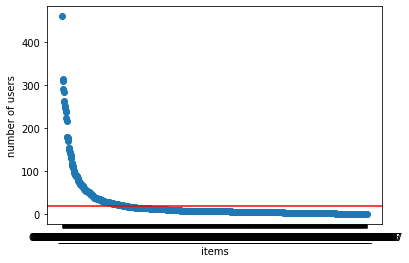

In [8]:
#%matplotlib qt

plt.scatter(users_by_item.item, users_by_item.user)
plt.axhline(y=users_by_item.user.mean(), color='r', linestyle='-')
#plt.yscale('log')
plt.ylabel('number of users')
plt.xlabel('items')
plt.show()